# Import libs & download databases

In [ ]:
!pip install neurokit2 wfdb

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import neurokit2 as nk
import wfdb
import keras
import scipy
import numpy
import pandas
from wfdb import plot
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Reading record files & annotation

In [ ]:
datafolder = "" # путь к папке с ЭКГ
SAMPLES = 700000

def get_rr_intervals(datafolder, filename, sample_count=-1, to_plot=False):
    """ Возвращает RR-интервалы для указанного файла в папке
        Args:
            sample_count: int, количество семплов для прочтения
            to_plot: bool, если  True - строит график ЭКГ
        Returns:
            list, список интервалов между R-пиками в секундах
    """
    filepath = datafolder + filename
    # Reading the record file and annotation
    if sample_count < 0:
      annot = wfdb.rdann(filepath,"atr")
      record = wfdb.rdrecord(filepath, channels=[0])
    else:
      annot = wfdb.rdann(filepath,"atr", sampto=sample_count)
      record = wfdb.rdrecord(filepath, sampto=sample_count, channels=[0])
    wave = record.__dict__["p_signal"][:,0]

    SMLPRATE = record.fs
    if to_plot:
        print(f"Sampling frequency is {SMLPRATE}")
        # Plot wave
        plot.plot_items(wave, ann_samp=[annot.sample], fs=SMLPRATE, time_units='seconds')
    return find_rr_int_in_signal(wave, SMLPRATE)


def find_rr_int_in_signal(signal, sampl_rate):
    """ Возвращает список RR-интервалов в сигнале.
        Args:
            signal: list, список семплов сигнала
            sampl_rate: int, частота дискретизации
        Returns:
            list, список интервалов между R-пиками в секундах
    """
    #Clean wave for R-peaks detection
    cleanedwave = nk.ecg_clean(signal, sampl_rate, "neurokit")
    # Find R-peaks
    rs, info = nk.ecg_peaks(cleanedwave, sampl_rate, "neurokit")
    intervals = []
    prevsample = 0 
    for smpl in info["ECG_R_Peaks"]:
        nsmpl = smpl/sampl_rate
        intr = nsmpl - prevsample
        intervals.append(intr)
        prevsample = nsmpl
    return intervals
    

In [ ]:
#Get all recordnames in data folder 
files = os.listdir(datafolder)
filenames = list(set([f.split('.')[0] for f in files]))
filenames.remove("ANNOTATORS")
filenames.remove("RECORDS")
filenames.remove("SHA256SUMS")

In [ ]:
for record_name in filenames:
    rcrd = wfdb.rdrecord(datafolder + record_name, channels=[0])
    ann = wfdb.rdann(datafolder + record_name,"atr")
    print(f"{record_name}:")
    print("\tFrequency: " + str(rcrd.fs)) # частота дискретизации
    print("\tSignal length, samples: " + str((rcrd.sig_len))) # количество семплов
    print("\tSignal length: " + str((rcrd.sig_len / rcrd.fs))) # длительность в часах


<h1>Preparing dataset<h1>

In [ ]:
WINDOW_SIZE = 40

# From:  
# https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb
def sequential_window_dataset(series, window_size):
    # Without overlap between samples
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds

In [ ]:
def read_scale_intervals(filenames, folder, scaler, samples_count):
    """ Возвращает список интервалов по каждой записи.
        Args:
            filenames: list of strings, список имен файлов-записей, которые нужно прочитать
            folder: string, папка с записями
            scaler: sklearn scaler, с помощью которого осуществляется нормализация 
            samples_count: int, будет прочтено [0:samples_count] семплов в записи 
        Returns:
            list of lists, список интервалов по каждому сигналу - каждый сигнал в 1 списке
    """
    intervals_by_rec = []
    rec_split_indices = [0]
    for fn in filenames:
        rrs = get_rr_intervals(folder, fn, samples_count)
        intervals_by_rec.append(rrs)
        next_idx = rec_split_indices[-1] + len(rrs)
        rec_split_indices.append(next_idx)
    flat_intervals = [item for sublist in intervals_by_rec for item in sublist]
    print(f"Length of flat intevals list: {len(flat_intervals)}")
    intervals = numpy.array(flat_intervals)
    print(f"Split indices: {rec_split_indices}")
    return scale_and_split(intervals, scaler, rec_split_indices[1:-1])

def scale_and_split(arr_values, scaler, split_indcs):
    """ Скалирует значения с помощью скейлера и разделяет их по индексам в подмассивы
        Args:
            arr_values: 1d numpy array, значения для скалирования
            scaler: sklearn scaler, скейлер 
            split_indcs: int or 1-D array, индексы, по которым осуществляется разделение
        Returns:
            list of arrays, список массивов скалированных значений из arr_values, 
            каждый массив получен разбиением по split_indcs
    """
    prepared_values = arr_values.reshape((-1, 1))# for min-max: (-1, 1), for standard: (1, -1)
    values_transformed = scaler.fit_transform(prepared_values)
    result = values_transformed.flatten()
    split_values = numpy.split(result, split_indcs)
    split_values = [row[numpy.isfinite(row)] for row in split_values]
    return split_values

def create_dataset_from_sequences(sequences, window_width):
    """ Создает датасет с непересекающимся окном из последовательностей
        Args:
            sequences: iterable of iterables, 
            window_width: int, ширина окна для входов
        Returns:
            prefetched Tensorflow dataset, batch_size=1
    """
    result = None
    for seq in sequences:
        step_ds = sequential_window_dataset(seq, window_width)
        if not result:
            result = step_ds
        else:
            result = result.concatenate(step_ds)
    return result.batch(1).prefetch(1)


In [ ]:
# Test
test_scaler = MinMaxScaler()
ints = read_scale_intervals(filenames[:2], datafolder, test_scaler, SAMPLES)
test_dataset = create_dataset_from_sequences(ints, WINDOW_SIZE)
test_counter = 10
for x, y in test_dataset:
    x = x.numpy()
    y = y.numpy()
    print(x[:,-4 :, :], y[:, :3, :])

In [ ]:
scaler = MinMaxScaler()
train_border = math.floor(len(filenames) * 0.8)
scaled_intervals_train = read_scale_intervals(filenames[:train_border], datafolder, scaler, SAMPLES)
print(f"Length of intervals array: {len(scaled_intervals_train)}")

print(f"Length of intervals for training ds: {len(scaled_intervals_train)}")
train_ds = create_dataset_from_sequences(scaled_intervals_train, WINDOW_SIZE)
scaled_intervals_valid = read_scale_intervals(filenames[train_border:], datafolder, scaler, SAMPLES)
valid_ds = create_dataset_from_sequences(scaled_intervals_valid, WINDOW_SIZE)

<h1>Training Model</h1>

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential([
  keras.layers.LSTM(50, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1], dropout=0.2),
  keras.layers.LSTM(100, return_sequences=True, stateful=True, dropout=0.2),
  keras.layers.Dense(1, activation="sigmoid")
])

reset_states = ResetStatesCallback()
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", mode='min')
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            60400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS_COUNT = 5
history = model.fit(train_ds, epochs=EPOCHS_COUNT,
                    callbacks=[reset_states], 
                    validation_data=valid_ds)

In [ ]:
# Saving model
save_path = "" # путь до папки, в которую сохранить модель
model.save(save_path)

<h1>Prediction</h1>

In [ ]:
load_path = ""
model = tf.keras.models.load_model(load_path) # путь до папки, из которой модель загрузить

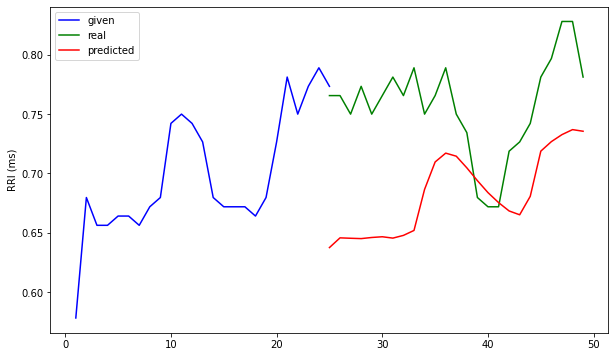

In [ ]:
import random 
import statistics as stats


plt.figure(figsize=(10, 6))
n_intervals = 25

random_record = datafolder + random.choice(filenames)
ann = wfdb.rdann(random_record,"atr", sampfrom=SAMPLES)
rec = wfdb.rdrecord(random_record, sampfrom=SAMPLES, channels=[0])
rr_intervals = find_rr_int_in_signal(rec.__dict__["p_signal"][:,0], rec.fs)
intervs = numpy.array(rr_intervals[0:n_intervals])
goal = rr_intervals[n_intervals:n_intervals * 2]

prediction_scaler = MinMaxScaler()
intervs = intervs.reshape((-1, 1))
prediction_scaler = prediction_scaler.fit(intervs)
input_seq = prediction_scaler.transform(intervs).reshape(1, n_intervals, 1)
pred = model.predict(input_seq)
standard_pred = prediction_scaler.inverse_transform(pred.reshape(1, -1))

plt.plot(range(1, n_intervals + 1), intervs, label="given", color="blue")
plt.plot(range(n_intervals, n_intervals*2), goal, label="real", color="green")
plt.plot(range(n_intervals, n_intervals*2), standard_pred[0], label="predicted", color="red")
plt.ylabel("RRI (ms)")
plt.legend()
plt.show()

In [ ]:
print("Prediction:")
print(standard_pred)
print("\nActual:")
print(goal)

Prediction:
[[0.63748485 0.64567846 0.64533544 0.64504516 0.6459878  0.64660454
  0.6454625  0.64775294 0.65192914 0.68651164 0.7096591  0.7171149
  0.7145313  0.7047019  0.6939036  0.6838191  0.6754345  0.66836244
  0.6651235  0.6806889  0.71879566 0.7268238  0.73271424 0.73693746
  0.73556435]]

Actual:
[0.765625, 0.765625, 0.75, 0.7734375, 0.75, 0.765625, 0.78125, 0.765625, 0.7890625, 0.75, 0.765625, 0.7890625, 0.75, 0.734375, 0.6796875, 0.671875, 0.671875, 0.71875, 0.7265625, 0.7421875, 0.78125, 0.796875, 0.828125, 0.828125, 0.78125]
